# The Battle of neighbourhoods Capstone Project: Moving to Oslo

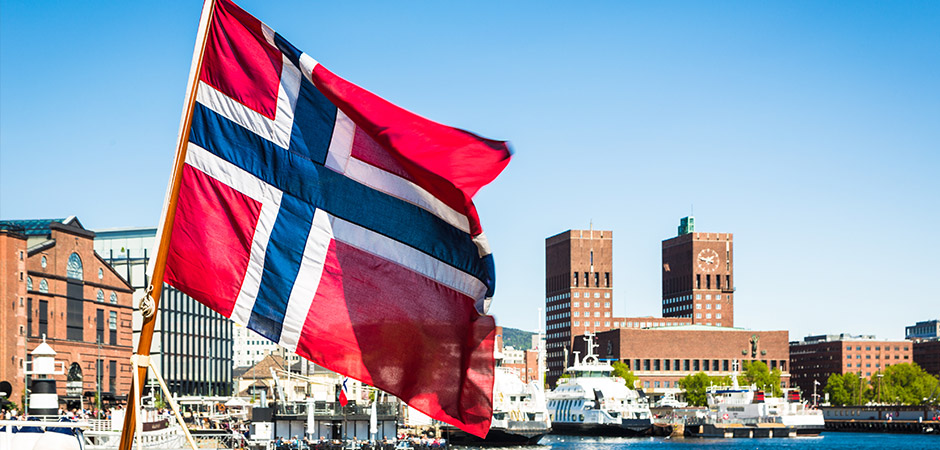

# 1.Introduction

### Problem Background:

Oslo is relatively small capital, but it has a long history and a charming range of old city quarters which each come with their own distinct character. Oslo is also one of the the fastest-growing capitals in Europe, and in recent years, some of its industrial areas have been turned into the most attractive and modern neighbourhoods for its ever-expanding population.
The Akerselva River splits Oslo into the western and eastern districts. Officially, the city is divided into 15 boroughs or municipalities, which are largely self-governed. Each is responsible for its own clinics, kindergartens and other public services.
The west is where established Norwegian families, the wealthy and most expats live, especially diplomats.

### Problem Definition

The goal of this exercise  is to identify suitable  areas to live in Oslo for a family with children and characterize them in terms of their socioeconomic features.

### Target Audience

- The main audience  would be people planning or relocating to Oslo specially families as the analysis will be focused in that segment.
- Anybody interested in understanding Oslo
- Data Scientists, who want to implement some of the most used Exploratory Data Analysis techniques to obtain necessary data, analyze it, and, finally be able to tell a story out of it.

# 2.Data

  - We will get The Names of Major Districts and Population from Wikipedia; https://en.wikipedia.org/wiki/List_of_boroughs_of_Oslo'
  - Geopy will be used  to geolocate  these districts
  - Foursquare API will be used to explore neighborhoods in Oslo, get the most common venue categories in each neighborhood, use the k-means clustering algorithm to find similar neighborhoods, use the Folium library to visualize the neighborhoods in Oslo and their emerging clusters.
  - Finally we will used data downloaded from Norway statistics department to further  characterize the districts of interest. https://data.ssb.no/api/v0/dataset?lang=en. the data will be downloaded and manipulated  separately as it goes beyond this exercise  the use of the provided API

# 3.Methodology

The approach  will be as described below
 - Get a list of neighborhoods in Oslo
 - Get the geographical coordinates of each neighborhood using Geopy libraries 
 - Use the geographical coordinates of each neighborhood and pass them one by one to the Foursquare API, to obtain a list of venues in the neighborhood within a given radius
 - Perform k-means clustering on the neighborhood venues data to cluster neighborhoods into groups that are similar by venue type
 - Analyze socioeconomic data for the districts in Oslo  and relate it to the identified clusters to identify neighborhoods  where a family with school age children might want to live


### We start importing the required libraries

In [2]:

# import necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import requests
import json
from bs4 import BeautifulSoup
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline
print('Packages installed  :)')

Packages installed  :)


## 3.1. Data acquisition and transformation.


## We scrape  Oslo neighborhoods data from wikipedia using beatiful soup library

In [3]:
# Get the District data using beautiful soup 
url='https://en.wikipedia.org/wiki/List_of_boroughs_of_Oslo'
result = requests.get(url)
data_html = BeautifulSoup(result.content)
# Now we will read the data into a Pandas Dataframe
soup = BeautifulSoup(str(data_html))
neigh = soup.find('table')
table_str = str(neigh.extract())
df_district = pd.read_html(table_str)[0]
#df_district


In [4]:
## Lets do some cleaning for column we do not need
df_district.drop(['Area','Number'],axis=1,inplace=True)
#df_district


### We do some data cleaning and add data for an extra neighborhood

Though Sandvika is not  part of Oslo  is a popular residential area in the proximity so we will add it using Baerum municipality data as proxy. The data was obtained from Norway statistics department

In [5]:
#append row to the dataframe
new_row = {'Borough':'Sandvika', 'Residents':121000,}
df_district = df_district.append(new_row, ignore_index=True)
print(' The initial district data looks like this')
df_district.head(16)

 The initial district data looks like this


,Borough,Residents
0,Alna,49 801
1,Bjerke,33 422
2,Frogner,59 269
3,Gamle Oslo,58 671
4,Grorud,27 707
5,Grünerløkka,62 423
6,Nordre Aker,52 327
7,Nordstrand,52 459
8,Sagene,45 089
9,St. Hanshaugen,38 945


## 3.2 Use Geopy to obtain Latitude and Longitude of neighborhoods

In [6]:
import geopy.geocoders
from geopy.geocoders import Nominatim
geopy.geocoders.options.default_timeout = 7
geolocator = Nominatim(user_agent="Oslo")
df_district['Major_Dist_Coord']= df_district['Borough'].apply(geolocator.geocode).apply(lambda x: (x.latitude, x.longitude))
df_district[['Latitude', 'Longitude']] = df_district['Major_Dist_Coord'].apply(pd.Series)

df_district.drop(['Major_Dist_Coord'], axis=1, inplace=True)
df_district.head(15)

,Borough,Residents,Latitude,Longitude
0,Alna,49 801,59.932417,10.835276
1,Bjerke,33 422,59.941395,10.829208
2,Frogner,59 269,59.922224,10.706649
3,Gamle Oslo,58 671,59.899237,10.734767
4,Grorud,27 707,59.961424,10.880549
5,Grünerløkka,62 423,59.925471,10.777421
6,Nordre Aker,52 327,59.953638,10.756412
7,Nordstrand,52 459,54.487378,8.865286
8,Sagene,45 089,59.938273,10.765849
9,St. Hanshaugen,38 945,59.927950,10.738958


### Nordstrand District seem to off position so we are going to fix it. We obtain the correct coordinates and change them

In [6]:
## Getting Nordstrand coordinates using Geocopy

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="Oslo Coord")
location = geolocator.geocode("Nordstrand, Oslo")
print(location.address)
print('The geographical coordinates of Nordstrand are,',location.latitude,location.longitude)

Nordstrand, Nordstrandveien, Øvre Ljanskollen, Sæter, Nordstrand, Oslo, 1170, Norge
The geographical coordinates of Nordstrand are, 59.8635246 10.7858304


This seems more correct so now I am going to change the value in the dataframe.
 The Dataframe with the correct coordinates will look like this

In [7]:
# This is the position we want to change
#df_district.at[7,'Longitude']
df_district.at[7,'Latitude']=59.8635246
df_district.at[7,'Longitude']=10.7858304
df_district

,Borough,Residents,Latitude,Longitude
0,Alna,49 801,59.932417,10.835276
1,Bjerke,33 422,59.941395,10.829208
2,Frogner,59 269,59.922224,10.706649
3,Gamle Oslo,58 671,59.899237,10.734767
4,Grorud,27 707,59.961424,10.880549
5,Grünerløkka,62 423,59.925471,10.777421
6,Nordre Aker,52 327,59.953638,10.756412
7,Nordstrand,52 459,59.863525,10.785830
8,Sagene,45 089,59.938273,10.765849
9,St. Hanshaugen,38 945,59.927950,10.738958


## 3.3 Explore Neighborhoods in Oslo.  

### 3.3.1 Visualize Oslo Neighborhoods in a map using folium 

### We obtain Oslo coordinates from Geopy

In [8]:
## Getting Oslo coordinates using Geopy

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="Oslo Coord")
location = geolocator.geocode("Oslo")
print(location.address)
print('The geographical coordinates of Oslo are,',location.latitude,location.longitude)


Oslo, 0026, Norge
The geographical coordinates of Oslo are, 59.9133301 10.7389701


### And plot the neighborhoods using folium

In [10]:
#Create list with the Boroughs (to be used later)
boroughs = df_district['Borough'].unique().tolist()
# This will color categorize each borough
borough_color = {}
for Borough in boroughs:
    borough_color[Borough]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3)) #Random color
## Create the map    
map_oslo = folium.Map(location=[59.9133301,10.7389701], zoom_start=11)

# add markers to map
for lat, lng, Borough, in zip(df_district['Latitude'], 
                             df_district['Longitude'],
                             df_district['Borough']):
    label_text = Borough + ' - ' 
    label = folium.Popup(label_text)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color=borough_color[Borough],
        fill_color=borough_color[Borough],
        fill_opacity=0.8).add_to(map_oslo)  
    
map_oslo

## 3.4 Explore Areas with Foursquare API

### Define Foursquare credentials  that i will not show here

In [11]:
CLIENT_ID = 'TBDZHFFO3MMND5HCUBVABQEK2HINXNPSMX34OUP2JEZYY1UG' # your Foursquare ID
CLIENT_SECRET = 'DLHDG2IFHNI5XEVUCKX12MZEB0LUDFWIYKXW3IN4EDNTFXW4' # your Foursquare Secret
VERSION = '20200701'
#print('Your credentials:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

### and create the get request url  using Foursquare ID  to look for venues within 1000 meters
  



In [12]:
radius = 1000
LIMIT = 500

def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'Dist_Latitude', 
                  'Dist_Longitude', 
                  'Venue', 
                  'Venue_Lat', 
                  'Venue_Long', 
                  'Venue_Category']
    
    return(nearby_venues)

### Use the getNearbyVenuesfunction on each neighborhood to Create the Dataframe of Venues Around Those 15 areas in Oslo


In [14]:
#Reasign the name of the main dataframe for clarity. 
df_Oslo=df_district
#Create new dataframe of venues
Oslo_Venues = getNearbyVenues(names=df_Oslo['Borough'],
                                   latitudes=df_Oslo['Latitude'],
                                   longitudes=df_Oslo['Longitude']
                                  )
print ("Shape of the Venues Dataframe: ", Oslo_Venues.shape)
Oslo_Venues.tail(3)

Alna
Bjerke
Frogner
Gamle Oslo
Grorud
Grünerløkka
Nordre Aker
Nordstrand
Sagene
St. Hanshaugen
Stovner
Søndre Nordstrand
Ullern
Vestre Aker
Østensjø
Sandvika
Shape of the Venues Dataframe:  (590, 7)


,District,Dist_Latitude,Dist_Longitude,Venue,Venue_Lat,Venue_Long,Venue_Category
587,Sandvika,59.890726,10.527743,Lakseberget,59.891921,10.536710,Harbor / Marina
588,Sandvika,59.890726,10.527743,Bergensbanen,59.894937,10.532205,Moving Target
589,Sandvika,59.890726,10.527743,Bærum Roklubb,59.885958,10.535703,Harbor / Marina


### resulting in 590 venues

### Now we count venues by district

In [15]:
## Counting how many venues by district
Oslo_Venues_count = Oslo_Venues.groupby('District').count().reset_index()
Oslo_Venues_count[['District', 'Venue']]


,District,Venue
0,Alna,24
1,Bjerke,10
2,Frogner,100
3,Gamle Oslo,24
4,Grorud,11
5,Grünerløkka,76
6,Nordre Aker,27
7,Nordstrand,22
8,Sagene,83
9,Sandvika,29


As we can see there are not many datapoints and these are mostly concentrated ina  few districts

### and count  the total unique categories  that are 143

In [16]:
print (Oslo_Venues['Venue_Category'].value_counts())

Grocery Store    41
Café             36
Bakery           28
Coffee Shop      25
Park             17
                 ..
Golf Course       1
Moving Target     1
Beer Bar          1
Trail             1
Creperie          1
Name: Venue_Category, Length: 143, dtype: int64


## 3.5: Analyze Each District and manipulate data

### We first convert Venue Category variable into dummy variables.

In [17]:
### Use One Hot Encoding to Get More Information about the Venue Categories 
Oslo_Venues_onehot = pd.get_dummies(Oslo_Venues[['Venue_Category']], prefix="", prefix_sep="")

### add district column back to dataframe
Oslo_Venues_onehot['District'] = Oslo_Venues['District'] 
### move district column to the first column
fixed_columns = [Oslo_Venues_onehot.columns[-1]] + list(Oslo_Venues_onehot.columns[:-1])
Oslo_Venues_onehot = Oslo_Venues_onehot[fixed_columns]
###Oslo_Venues_onehot.head(3)
Oslo_Venues_onehot.head(3)

,District,Advertising Agency,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Bakery,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Water Park,Wine Bar,Wine Shop,Yoga Studio
0,Alna,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Alna,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Alna,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Group rows by neighborhood and by taking the mean of the frequency of occurrence of each Venue Category.

In [18]:
Oslo_Venues_Grouped = Oslo_Venues_onehot.groupby('District').mean().reset_index()
Oslo_Venues_Grouped.index = np.arange(1, len(Oslo_Venues_Grouped)+1)
Oslo_Venues_Grouped.head()

,District,Advertising Agency,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Bakery,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Water Park,Wine Bar,Wine Shop,Yoga Studio
1,Alna,0.0,0.00,0.041667,0.000000,0.000000,0.041667,0.041667,0.0,0.041667,...,0.041667,0.0,0.041667,0.00,0.0,0.0,0.00,0.0,0.000000,0.00
2,Bjerke,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.00,0.0,0.0,0.00,0.0,0.000000,0.00
3,Frogner,0.0,0.01,0.000000,0.030000,0.000000,0.000000,0.000000,0.0,0.070000,...,0.000000,0.0,0.000000,0.01,0.0,0.0,0.01,0.0,0.030000,0.01
4,Gamle Oslo,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.00,0.0,0.0,0.00,0.0,0.000000,0.00
5,Grorud,0.0,0.00,0.000000,0.090909,0.090909,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.00,0.0,0.0,0.00,0.0,0.090909,0.00


### And see the frequency of the categories

In [19]:
num_top_venues = 5

for places in Oslo_Venues_Grouped['District']:
    print("%%%%%%%%%"+places+"%%%%%%%%")
    temp = Oslo_Venues_Grouped[Oslo_Venues_Grouped['District'] == places].T.reset_index()
    temp.columns = ['Venue','Freq']
    temp = temp.iloc[1:]
    temp['Freq'] = temp['Freq'].astype(float)
    temp = temp.round({'Freq': 2})
    print(temp.sort_values('Freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

%%%%%%%%%Alna%%%%%%%%
                    Venue  Freq
0  Furniture / Home Store  0.17
1           Grocery Store  0.12
2           Metro Station  0.12
3             Bus Station  0.08
4               Pet Store  0.08


%%%%%%%%%Bjerke%%%%%%%%
                  Venue  Freq
0         Grocery Store   0.3
1  Gym / Fitness Center   0.2
2                 Hotel   0.1
3           Supermarket   0.1
4           Pizza Place   0.1


%%%%%%%%%Frogner%%%%%%%%
               Venue  Freq
0               Café  0.08
1             Bakery  0.07
2        Coffee Shop  0.05
3              Hotel  0.04
4  Indian Restaurant  0.04


%%%%%%%%%Gamle Oslo%%%%%%%%
                     Venue  Freq
0            Boat or Ferry  0.29
1  Scandinavian Restaurant  0.08
2                   Castle  0.08
3             Bathing Area  0.04
4             Burger Joint  0.04


%%%%%%%%%Grorud%%%%%%%%
               Venue  Freq
0      Metro Station  0.18
1  Convenience Store  0.09
2        Pizza Place  0.09
3        Bus Station  0.09
4 

### Create a DataFrame with Top 10 Venues for Each District


In [20]:
## Define a Function to select the top 10 rows (According to the Values) 

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
District_top10_venues_sorted = pd.DataFrame(columns=columns)
District_top10_venues_sorted['District'] = Oslo_Venues_Grouped['District']

for ind in np.arange(Oslo_Venues_Grouped.shape[0]):
    District_top10_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Oslo_Venues_Grouped.iloc[ind, :], num_top_venues)

    
District_top10_venues_sorted.index = np.arange(1, len(District_top10_venues_sorted)+1)
District_top10_venues_sorted.head()

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Alna,Furniture / Home Store,Metro Station,Grocery Store,Bus Station,Pet Store,Spanish Restaurant,Market,Hotel,Bakery,Toy / Game Store
2,Bjerke,Grocery Store,Gym / Fitness Center,Farm,Hotel,Supermarket,Pizza Place,Café,Yoga Studio,Dog Run,Falafel Restaurant
3,Frogner,Café,Bakery,Coffee Shop,Hotel,Scandinavian Restaurant,Indian Restaurant,Pizza Place,Park,Pub,Burger Joint
4,Gamle Oslo,Boat or Ferry,Scandinavian Restaurant,Castle,Mexican Restaurant,Bathing Area,Other Nightlife,Chinese Restaurant,Seafood Restaurant,Café,Burger Joint
5,Grorud,Metro Station,Wine Shop,Asian Restaurant,Athletics & Sports,Bus Station,Gym,Grocery Store,Pizza Place,Convenience Store,Supermarket


## 3.6: Cluster Neighborhoods

### Clustering the Oslo Districts (Neighborhoods) using K-Means

### We start using the Elbow method to determine the optimal number of  clusters

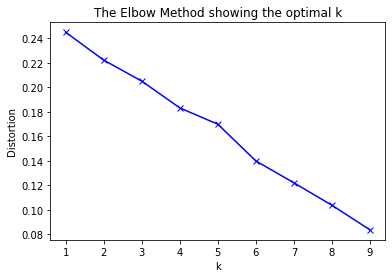

In [21]:
# Identify the optimal number of clusters
# try with 10 different values of k to find the best one
# find the distances
from scipy.spatial.distance import cdist
Ks = 10
distortions = []

Oslo_clustering = Oslo_Venues_Grouped.drop('District', 1)

for k in range(1, Ks):

    # run k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(Oslo_clustering)

    # find the distortion w.r.t each k
    distortions.append(
        sum(np.min(cdist(Oslo_clustering, kmeans.cluster_centers_, 'euclidean'), axis=1))
        / Oslo_clustering.shape[0]
    )

plt.plot(range(1, Ks), distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### The result is inconclusive suggesting that K-means method might not be the best option. Nevertheless We will use k=5 for the sake of the learning exercise

In [22]:
# set number of clusters
kclusters = 5

Oslo_clustering = Oslo_Venues_Grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Oslo_clustering)

# check cluster labels generated for each row in the dataframe
print ("Check the  4Cluster labels :",  kmeans.labels_[0:14])

Check the  4Cluster labels : [0 2 1 1 4 1 1 1 1 1 1 3 3 0]


### Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood and merge it with our original df with districts and coordinates

In [23]:
# add clustering labels
District_top10_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
Oslo_merged = District_top10_venues_sorted

Oslo_merged.head()


,Cluster Labels,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,0,Alna,Furniture / Home Store,Metro Station,Grocery Store,Bus Station,Pet Store,Spanish Restaurant,Market,Hotel,Bakery,Toy / Game Store
2,2,Bjerke,Grocery Store,Gym / Fitness Center,Farm,Hotel,Supermarket,Pizza Place,Café,Yoga Studio,Dog Run,Falafel Restaurant
3,1,Frogner,Café,Bakery,Coffee Shop,Hotel,Scandinavian Restaurant,Indian Restaurant,Pizza Place,Park,Pub,Burger Joint
4,1,Gamle Oslo,Boat or Ferry,Scandinavian Restaurant,Castle,Mexican Restaurant,Bathing Area,Other Nightlife,Chinese Restaurant,Seafood Restaurant,Café,Burger Joint
5,4,Grorud,Metro Station,Wine Shop,Asian Restaurant,Athletics & Sports,Bus Station,Gym,Grocery Store,Pizza Place,Convenience Store,Supermarket


### And merge it with our original dataframe of districtcs and coordinates

In [24]:
## Merging dataframe 'most common venues ' with original Oslo districfs dataframe  'districts and coordinates'
Oslo_merged = Oslo_merged.join(df_district.set_index('Borough'), on='District')

Oslo_merged.head()

,Cluster Labels,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Residents,Latitude,Longitude
1,0,Alna,Furniture / Home Store,Metro Station,Grocery Store,Bus Station,Pet Store,Spanish Restaurant,Market,Hotel,Bakery,Toy / Game Store,49 801,59.932417,10.835276
2,2,Bjerke,Grocery Store,Gym / Fitness Center,Farm,Hotel,Supermarket,Pizza Place,Café,Yoga Studio,Dog Run,Falafel Restaurant,33 422,59.941395,10.829208
3,1,Frogner,Café,Bakery,Coffee Shop,Hotel,Scandinavian Restaurant,Indian Restaurant,Pizza Place,Park,Pub,Burger Joint,59 269,59.922224,10.706649
4,1,Gamle Oslo,Boat or Ferry,Scandinavian Restaurant,Castle,Mexican Restaurant,Bathing Area,Other Nightlife,Chinese Restaurant,Seafood Restaurant,Café,Burger Joint,58 671,59.899237,10.734767
5,4,Grorud,Metro Station,Wine Shop,Asian Restaurant,Athletics & Sports,Bus Station,Gym,Grocery Store,Pizza Place,Convenience Store,Supermarket,27 707,59.961424,10.880549


### Now we visualize the clusters on a map

In [ ]:
# create map
map_clusters = folium.Map(location=[59.9133301,10.7389701], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Oslo_merged['Latitude'], 
                                  Oslo_merged['Longitude'], 
                                  Oslo_merged['District'], 
                                  Oslo_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

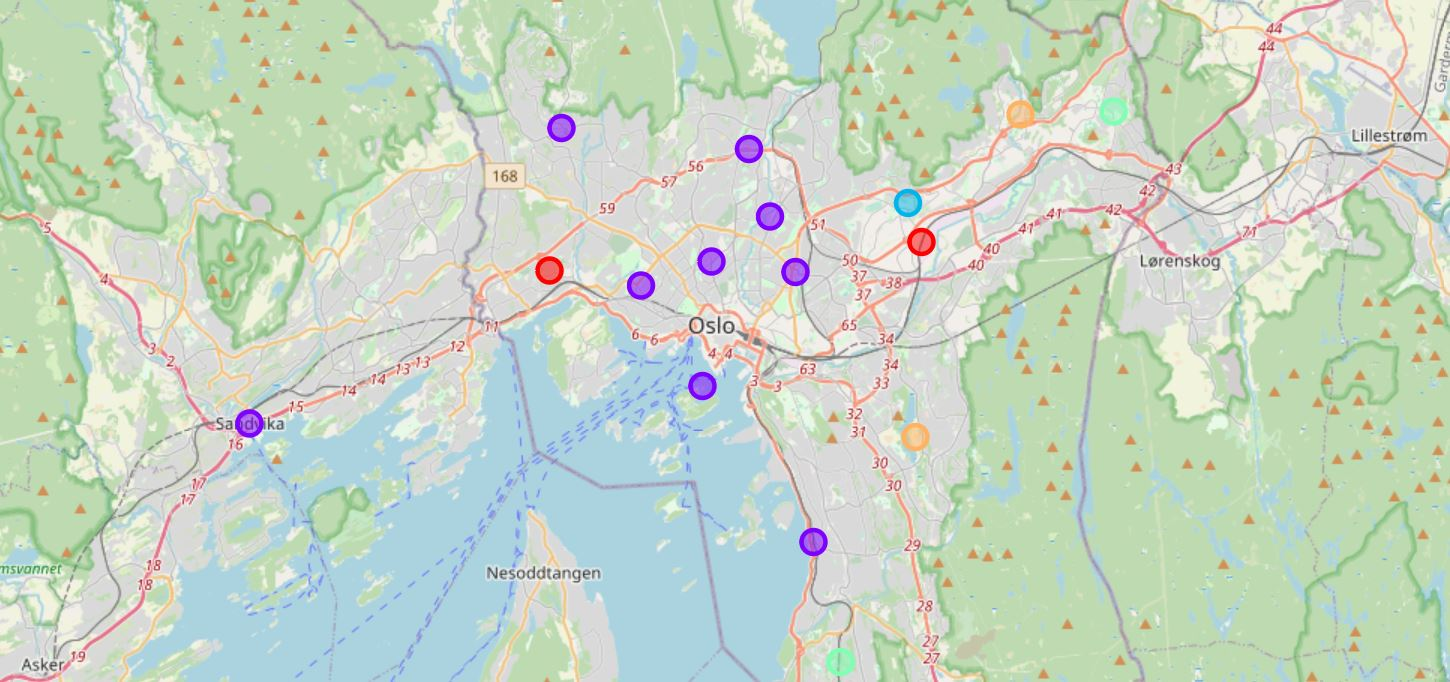

## 3.8 Explore the clusters 

We will examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, we can then assign a name to each cluster.

### First we create  new dataframe to count  venue categories

In [26]:
def total_venue_categories(df):
    df_all_venues = df['1st Most Common Venue']
    df_all_venues = df_all_venues.append(df['2nd Most Common Venue'])
    df_all_venues = df_all_venues.append(df['3rd Most Common Venue'])
    df_all_venues = df_all_venues.append(df['4th Most Common Venue'])
    df_all_venues = df_all_venues.append(df['5th Most Common Venue'])
    df_all_venues = df_all_venues.append(df['6th Most Common Venue'])
    df_all_venues = df_all_venues.append(df['7th Most Common Venue'])
    df_all_venues = df_all_venues.append(df['8th Most Common Venue'])
    df_all_venues = df_all_venues.append(df['9th Most Common Venue'])
    df_all_venues = df_all_venues.append(df['10th Most Common Venue'])
    df_cnt = df_all_venues.value_counts().to_frame().reset_index()
    df_cnt.columns = ['Venue Category', 'Venue Count']
    df_cnt.sort_values(by = 'Venue Count', ascending = False)
#return the top 10 venue categories
    return df_cnt.head(10)


### and then  show each cluster and  plot the category count in a barchart

### Cluster 0. Transportation hubs

In [27]:
Oslo_cluster0 = Oslo_merged.loc[Oslo_merged['Cluster Labels'] == 0, Oslo_merged.columns[[1] + list(range(2, Oslo_merged.shape[1]))]]
Oslo_cluster0

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Residents,Latitude,Longitude
1,Alna,Furniture / Home Store,Metro Station,Grocery Store,Bus Station,Pet Store,Spanish Restaurant,Market,Hotel,Bakery,Toy / Game Store,49 801,59.932417,10.835276
14,Ullern,Bus Station,Metro Station,Market,Light Rail Station,Harbor / Marina,Coffee Shop,Flower Shop,Electronics Store,Italian Restaurant,Burger Joint,34 596,59.925818,10.665132


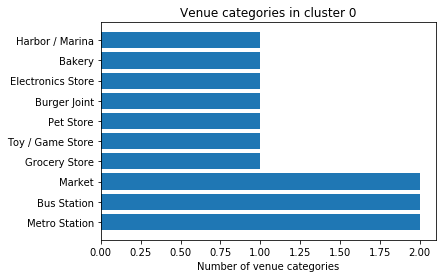

In [38]:
#count venue categories in all neighborhoods in the cluster
t0 = total_venue_categories(Oslo_merged[Oslo_merged['Cluster Labels'] == 0])

y_pos = np.arange(len(t0['Venue Category']))
plt.barh(y_pos, t0['Venue Count'], align='center')
plt.yticks(y_pos, t0['Venue Category'])
plt.xlabel('Number of venue categories')
plt.title('Venue categories in cluster 0')
 
plt.show()

Cluster 0 has a prevalence of transportation infrastructure like bus or metro station plus services for residents like markets and groceries

### Cluster 1. Residential Urban

In [29]:
Oslo_cluster1 = Oslo_merged.loc[Oslo_merged['Cluster Labels'] == 1, Oslo_merged.columns[[1] + list(range(2, Oslo_merged.shape[1]))]]
Oslo_cluster1

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Residents,Latitude,Longitude
3,Frogner,Café,Bakery,Coffee Shop,Hotel,Scandinavian Restaurant,Indian Restaurant,Pizza Place,Park,Pub,Burger Joint,59 269,59.922224,10.706649
4,Gamle Oslo,Boat or Ferry,Scandinavian Restaurant,Castle,Mexican Restaurant,Bathing Area,Other Nightlife,Chinese Restaurant,Seafood Restaurant,Café,Burger Joint,58 671,59.899237,10.734767
6,Grünerløkka,Grocery Store,Café,Bus Station,Park,Bakery,Bar,Gym / Fitness Center,Coffee Shop,Asian Restaurant,Botanical Garden,62 423,59.925471,10.777421
7,Nordre Aker,Bakery,Bus Stop,Gym,Grocery Store,Metro Station,Shopping Mall,Bus Station,Advertising Agency,Sushi Restaurant,Hotel,52 327,59.953638,10.756412
8,Nordstrand,Grocery Store,Beach,Fast Food Restaurant,Shopping Mall,Bakery,Supermarket,Sushi Restaurant,Juice Bar,Convenience Store,Restaurant,52 459,59.863525,10.785830
9,Sagene,Café,Sushi Restaurant,Coffee Shop,Park,Pizza Place,Bar,Bakery,Brewery,Gym,Grocery Store,45 089,59.938273,10.765849
10,Sandvika,Coffee Shop,Café,Restaurant,Harbor / Marina,Electronics Store,Fast Food Restaurant,Movie Theater,Moving Target,Sporting Goods Shop,Beach,121000,59.890726,10.527743
11,St. Hanshaugen,Bakery,Café,Scandinavian Restaurant,Coffee Shop,Park,Pizza Place,Indian Restaurant,Bar,Gym / Fitness Center,Thai Restaurant,38 945,59.927950,10.738958
15,Vestre Aker,Grocery Store,Ski Area,Metro Station,Restaurant,Café,Soccer Field,Lake,Scandinavian Restaurant,Disc Golf,Museum,50 157,59.958300,10.670319


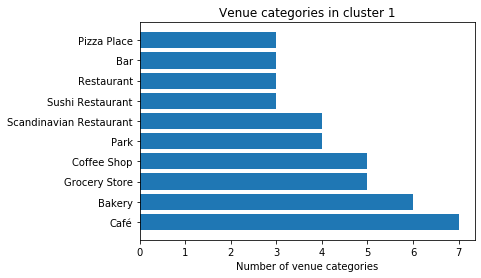

In [31]:
#count venue categories in all neighborhoods in the cluster
t0 = total_venue_categories(Oslo_merged[Oslo_merged['Cluster Labels'] == 1])

y_pos = np.arange(len(t0['Venue Category']))
plt.barh(y_pos, t0['Venue Count'], align='center')
plt.yticks(y_pos, t0['Venue Category'])
plt.xlabel('Number of venue categories')
plt.title('Venue categories in cluster 1')
 
plt.show()

This cluster comprises districs relatively close  to the urban centers and having a good variety of services and with prevalence of Coffe shops, bakeries and grocey stores that can be indicative of affluent urban residential areas



### Cluster 2. Residential Suburban

In [32]:
Oslo_cluster2 = Oslo_merged.loc[Oslo_merged['Cluster Labels'] == 2, Oslo_merged.columns[[1] + list(range(2, Oslo_merged.shape[1]))]]
Oslo_cluster2

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Residents,Latitude,Longitude
2,Bjerke,Grocery Store,Gym / Fitness Center,Farm,Hotel,Supermarket,Pizza Place,Café,Yoga Studio,Dog Run,Falafel Restaurant,33 422,59.941395,10.829208


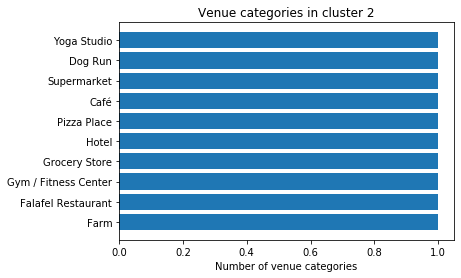

In [33]:
#count venue categories in all neighborhoods in the cluster
t0 = total_venue_categories(Oslo_merged[Oslo_merged['Cluster Labels'] == 2])

y_pos = np.arange(len(t0['Venue Category']))
plt.barh(y_pos, t0['Venue Count'], align='center')
plt.yticks(y_pos, t0['Venue Category'])
plt.xlabel('Number of venue categories')
plt.title('Venue categories in cluster 2')
 
plt.show()


Cluster 2 datapoints are limited so  we cannot really infer much  about it

### Cluster 3. Residential immigrant

In [34]:
Oslo_cluster3 = Oslo_merged.loc[Oslo_merged['Cluster Labels'] == 3, Oslo_merged.columns[[1] + list(range(2, Oslo_merged.shape[1]))]]
Oslo_cluster3

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Residents,Latitude,Longitude
12,Stovner,Gas Station,Video Game Store,Grocery Store,Department Store,Golf Course,Shopping Mall,Yoga Studio,Falafel Restaurant,Electronics Store,Eastern European Restaurant,33 316,59.962140,10.922823
13,Søndre Nordstrand,Grocery Store,Shopping Mall,Fast Food Restaurant,Gym,Athletics & Sports,Train Station,Stadium,Pharmacy,Farm,Falafel Restaurant,39 066,59.835944,10.798496


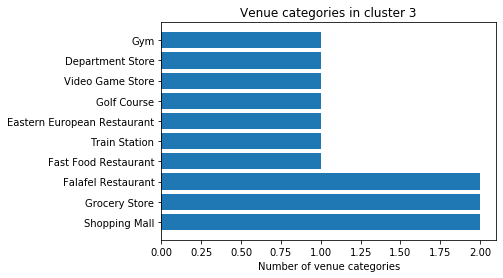

In [35]:
#count venue categories in all neighborhoods in the cluster
t0 = total_venue_categories(Oslo_merged[Oslo_merged['Cluster Labels'] == 3])

y_pos = np.arange(len(t0['Venue Category']))
plt.barh(y_pos, t0['Venue Count'], align='center')
plt.yticks(y_pos, t0['Venue Category'])
plt.xlabel('Number of venue categories')
plt.title('Venue categories in cluster 3')
 
plt.show()

Cluster 3 include suburban districts with prevalence of grocery stores and shopping mall. Presence of foreign restaurants might be indicative of immigrant population.


### Cluster 4. Residential Suburban

In [39]:
Oslo_cluster4 = Oslo_merged.loc[Oslo_merged['Cluster Labels'] == 4, Oslo_merged.columns[[1] + list(range(2, Oslo_merged.shape[1]))]]
Oslo_cluster4

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Residents,Latitude,Longitude
5,Grorud,Metro Station,Wine Shop,Asian Restaurant,Athletics & Sports,Bus Station,Gym,Grocery Store,Pizza Place,Convenience Store,Supermarket,27 707,59.961424,10.880549
16,Østensjø,Metro Station,Athletics & Sports,Shopping Mall,Yoga Studio,Supermarket,Grocery Store,Lake,Pizza Place,Convenience Store,Burger Joint,50 806,59.887563,10.832748


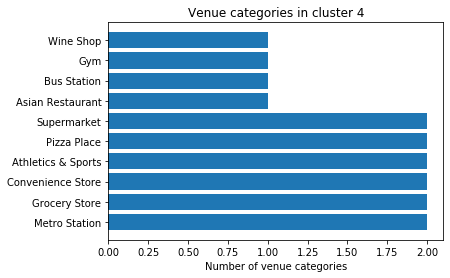

In [40]:
#count venue categories in all neighborhoods in the cluster
t0 = total_venue_categories(Oslo_merged[Oslo_merged['Cluster Labels'] == 4])

y_pos = np.arange(len(t0['Venue Category']))
plt.barh(y_pos, t0['Venue Count'], align='center')
plt.yticks(y_pos, t0['Venue Category'])
plt.xlabel('Number of venue categories')
plt.title('Venue categories in cluster 4')
 
plt.show()

Cluster 4 Prevalence of grocery shops, supermarkets, convenience store indicating residential areas

## 3.8 Characterize Districts using Socioeconomic data

### We import data downloaded to an excel file

In [52]:
# Import excel file with data
my_sheet = 'Summary' 
file_name = r'C:\Users\MyPC\Desktop\MOOC\DATA SCIENCE\APPLIED DATA SCIENCE CAPSTONE\Oslo Datasets\Households and income\INCOME_HOUSEHOLD.xlsx' 
df_Oslo1 = pd.read_excel(file_name, sheet_name = my_sheet)
print(df_Oslo1.head(10))

           Location                                Household Type  \
0  Bærum (Sandvika)                                All households   
1  Bærum (Sandvika)                                  Living alone   
2  Bærum (Sandvika)              Couple without resident children   
3  Bærum (Sandvika)       Couple with resident children 0-17 year   
4  Bærum (Sandvika)  Single mother/father with children 0-17 year   
5            Gamle                                 All households   
6            Gamle                                   Living alone   
7            Gamle               Couple without resident children   
8            Gamle        Couple with resident children 0-17 year   
9            Gamle   Single mother/father with children 0-17 year   

   Total income, median (NOK)  Income after taxes, median (NOK)  \
0                      852000                            642000   
1                      419000                            325000   
2                     1057000          

### ...select the data referring to the category couple with children

In [53]:
## Choose only relevenat columns
df_Oslo2=df_Oslo1[["Location","Household Type","Total income, median (NOK)","Number of households","Household Type/ Total Households"]]
df_Oslo2

,Location,Household Type,"Total income, median (NOK)",Number of households,Household Type/ Total Households
0,Bærum (Sandvika),All households,852000,53900,1.000000
1,Bærum (Sandvika),Living alone,419000,19797,0.367291
2,Bærum (Sandvika),Couple without resident children,1057000,11913,0.221020
3,Bærum (Sandvika),Couple with resident children 0-17 year,1515000,13919,0.258237
4,Bærum (Sandvika),Single mother/father with children 0-17 year,616000,2415,0.044805
...,...,...,...,...,...
80,Sentrum,All households,423000,909,1.000000
81,Sentrum,Living alone,361000,666,0.732673
82,Sentrum,Couple without resident children,679000,165,0.181518
83,Sentrum,Couple with resident children 0-17 year,629000,22,0.024202


In [62]:
# WE select only the category we are interested in
df_Oslo3 = df_Oslo2.loc[df_Oslo2["Household Type"] == "Couple with resident children 0-17 year"]
df_Oslo3.head()

,Location,Household Type,"Total income, median (NOK)",Number of households,Household Type/ Total Households
3,Bærum (Sandvika),Couple with resident children 0-17 year,1515000,13919,0.258237
8,Gamle,Couple with resident children 0-17 year,1020000,3991,0.127459
13,Grunelokka,Couple with resident children 0-17 year,1096000,4115,0.116850
18,Sagene,Couple with resident children 0-17 year,1173000,2968,0.116164
23,St. Hanshaugen,Couple with resident children 0-17 year,1259000,2220,0.097471


In [39]:
# Select Relevant Household type and sort
df_Oslo3 = df_Oslo2[['Location',"Household Type/ Total Households",'Total income, median (NOK)']]
df_Oslo3.sort_values(by=['Household Type/ Total Households'],inplace= True,ascending=False)
#df_Oslo3


C:\Users\MyPC\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [63]:
df_Oslo3.set_index('Location', inplace=True)
df_Oslo3.head()


,Household Type,"Total income, median (NOK)",Number of households,Household Type/ Total Households
Location,,,,
Bærum (Sandvika),Couple with resident children 0-17 year,1515000,13919,0.258237
Gamle,Couple with resident children 0-17 year,1020000,3991,0.127459
Grunelokka,Couple with resident children 0-17 year,1096000,4115,0.116850
Sagene,Couple with resident children 0-17 year,1173000,2968,0.116164
St. Hanshaugen,Couple with resident children 0-17 year,1259000,2220,0.097471


### and do some further cleaning to focus on ratio of families with children over total households

In [80]:
# Eliminate income column that we dont need for the next chart
drop_these = ['Total income, median (NOK)','Number of households']
df_Oslo4 = df_Oslo3.drop(columns=drop_these)
df_Oslo4.sort_values("Household Type/ Total Households",inplace = True)
df_Oslo4.head()

,Household Type,Household Type/ Total Households
Location,,
Sentrum,Couple with resident children 0-17 year,0.024202
Frogner,Couple with resident children 0-17 year,0.093816
St. Hanshaugen,Couple with resident children 0-17 year,0.097471
Sagene,Couple with resident children 0-17 year,0.116164
Grunelokka,Couple with resident children 0-17 year,0.116850


### Visualize in a barchart the most family oriented districts

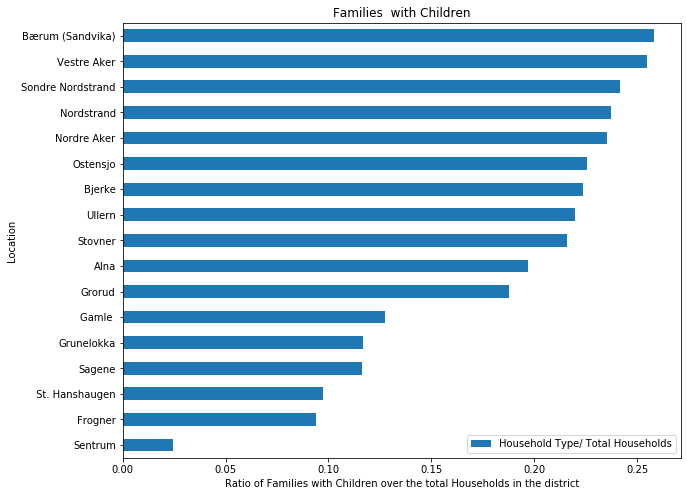

In [83]:
df_Oslo4.plot.barh(figsize=(10,8))
plt.xlabel('Ratio of Families with Children over the total Households in the district') # add to x-label to the plot
#plt.ylabel('Household Type/ Total Households') # add y-label to the plot
plt.title('Families  with Children') # add title to the plot

plt.show()

### and we can see the districts with the highest ratio of families with children

### Visualize the relationship between household income and  household type

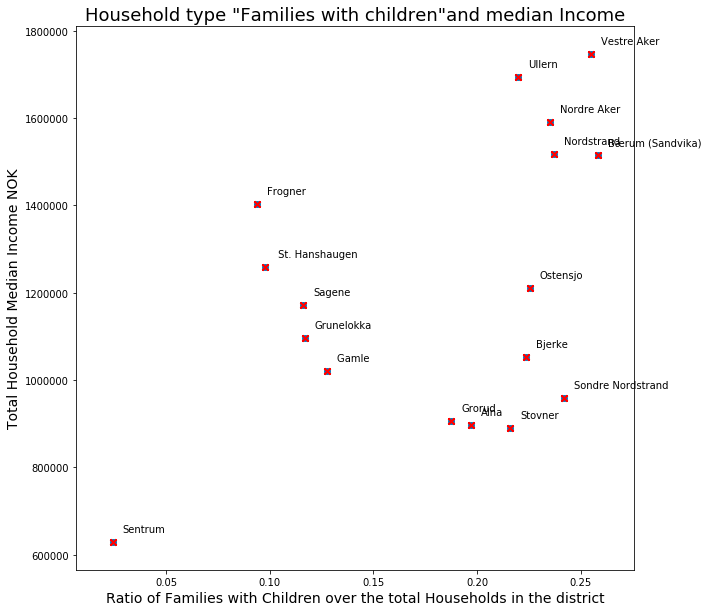

In [84]:
# Plot a scatter chart and add labels
                     
x = df_Oslo3['Household Type/ Total Households'].values
y = df_Oslo3['Total income, median (NOK)'].values
types = df_Oslo3.reset_index()['Location'].values

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x, y)

ax.set_xlabel('Ratio of Families with Children over the total Households in the district', fontsize=14)
ax.set_ylabel('Total Household Median Income NOK', fontsize=14)
ax.set_title('Household type "Families with children"and median Income', fontsize=18)

for i, txt in enumerate(types):
    ax.annotate(txt, (x[i], y[i]), xytext=(10,10), textcoords='offset points')
    plt.scatter(x, y, marker='x', color='red')


This scatter charts shows clearly  where families are prevalent and  the income level.We can see three clear groups.
On the X axis values indicate the ratio of families with children over the total housholds in the district.
- Group 1 high income and high proportion (>20%) of families with children. Top right corner
- Group 2  middle/low household income and high proportion of families with children. Botton right corner.
- Group 3. Middle income and low proportion of households with children. Most of the housholds in these areas are single  persons and is also reflected  in the average household income.



# 4. Results

Through the foursquare location analysis  we identified 3  potential residential clusters one urban and three suburban. 
When looking at socioeconomic data we can further characterize  the districts within the clusters

Cluster 0. This is what i called Transportation center due to the presence in transportation infrastructure however  the two districts included here are reasonable locations for families though in opposite sides of the income scale while  Ullern is in the high income side and similar to the districts in  cluster 0, Alna would be in the lowest income group similar to location in cluster 2.  In my opinion these are examples of the limits of k-clustering with the limited data we have

Cluster 1. This group corresponds with groups 1 and 3, middle and high income locations
The most attractive locations for familes would be as they present the highest proportions of families with children. these districts also correspond to highest household income
- Nordre Aker
- Nordstrand
- Sandvika
- Vestre Aker
- Ostenjo

The rest of the districts in the cluster would be more intereting for households with one person

The other clusters 2,3 and 4 correspond almost perfectly with group 3 middle and low income.

Cluster 2. Also identified as residential suburban areas. Bjerke seems to be a location of choice for middle  income families

Cluster 3. Residential suburban Inmmigrant. The conclusion obtained from the location analysis is confirmed  when looking at socioeconomic data. Stovner and Sondre Nordstrand are indeed suburban residential areas with high % of families with children. These are also districts with the lowest household income

Cluster 4 Residential suburban. Grorud ,Ostenjo




# 5. Discussion

This was a good project to complete the  Coursera Capstone course and was definetly an excellent learning exercise as to complete it i had  to deal and figure out  how to solve a number of issues.
From the results standpoint there are some  positives and some negatives.
- The data points from Foursquare API  are limited and thus its is not really possible to reach strong conclusions out of it and should be taken with a pinch of salt. Another approach would be to do the same exercise with different  data sources like google maps API.In other cities where Foursquare is more popular results might be better
- K means  clustering is not the most relevant approach for clustering given the available data as the Elbow method didn't show any differences in the number of clusters.Number 5 was chosen for the sake of the learning exercise and though some clusters identified  really had some consistency like Cluster 1, it also resulted in confusing reults like with cluster 0
- The clustering is done based on the presence of similar categories, however a more focused analysis choosing only specific categories of interest might render better results.
- It was not posible  for me to obtain a geojson dataset with Oslo districts boundaries. Should it be available it could be used to better show  the socioeconomic features together with the clusters
- Interestingly the most affluent districts in Oslo have the highest number of datapoints mainly corresponding to Cluster0.
- Clustering did a decent job  if we consider income criteria. It did separate higher income areas from middle and lower income 


#  6. Conclusion 

To conclude this project i will say that it was definetly a very good learning exercise  were i had to use different libraries  to scrape websites, manipulate dataframes, visualize maps, use an external API, conduct clustering analysis using k-means method and plot charts. 
There are significant gaps on the quality of the data and how defensible the conclusions would be using only Foursquare data. Nevertheles as mentioned in the previous section the results are not completely off the reality of Oslo